<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter


BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg

    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

Python Environment:
 | Python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.9.0
 | NetworkX version: 3.3
 | NetworkX backend: None
 | CuGraph not installed, for better performance install it like this:
	pip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com

Ressources:
 | CPU: 12 cores


## Daten laden

In [2]:
G = utils.get_graph(GRAPH_PATH, PAPERS)

print(f"Number of nodes: {len(G.nodes)}")
G = utils.merge_duplicate_nodes(
    G, exclude_attributes=["label", "countries", "sourceID", "valid_until", "note"]
)
print(f"Number of nodes after removing duplicates: {len(G.nodes)}")

print(f"Number of edges: {len(G.edges)}")
G = utils.remove_duplicate_edges(G)
print(f"Number of edges after removing duplicates: {len(G.edges)}")

Number of nodes: 108053


Merging duplicate nodes:   0%|          | 0/89015 [00:00<?, ?it/s]

Number of nodes after removing duplicates: 89015
Number of edges: 126762


Removing duplicate edges:   0%|          | 0/126762 [00:00<?, ?it/s]

Number of edges after removing duplicates: 111962


## Which are the biggest officer clusters/cliques, and what percentage of Swiss officers are part of them?

In [16]:
def unweighted_project_officers_graph(G):
    undirected_G = G.to_undirected()

    officers_nodes = {node for node, data in undirected_G.nodes(data=True) if data.get("node_type") == "Officer"}

    connecting_entities = 0

    new_G = nx.Graph()
    for node in officers_nodes:

        # Check if the officer is related to an address or entity
        related_nodes = set()
        for neighbor in undirected_G.neighbors(node):
            neighbor_data = undirected_G.nodes[neighbor]
            if neighbor_data.get("node_type") == "Address" or neighbor_data.get("node_type") == "Entity":
                related_nodes.add(neighbor)

        # Add edges between officers if they share the same address or entity
        for related_node in related_nodes:
            for neighbor in undirected_G.neighbors(related_node):
                if neighbor in officers_nodes and neighbor != node:
                    related_data = undirected_G.nodes[related_node]
                    if related_data.get("node_type") == "Entity" and not new_G.has_edge(node, neighbor):
                        connecting_entities += 1
                    new_G.add_edge(node, neighbor)

    return new_G, connecting_entities

new_officers_graph, connecting_entities = unweighted_project_officers_graph(G)

In [17]:
num_nodes = len(new_officers_graph.nodes)
num_edges = len(new_officers_graph.edges)

print("Number of nodes in the new officers graph:", num_nodes)

all_officers_nodes = {node for node, data in G.nodes(data=True) if data.get("node_type") == "Officer"}

swiss_officers_nodes = {node for node, data in G.nodes(data=True) if utils.is_officer_from_country_name(G, node, "Switzerland")}

swiss_officers_to_all_officers_ratio = len(swiss_officers_nodes)/len(all_officers_nodes)

print(f"Ratio of swiss officers: {swiss_officers_to_all_officers_ratio}")
print()

print("Number of edges in the new officers graph:", num_edges)
print(f"Number of edges in the new officers graph which stem from entities: {connecting_entities} ({connecting_entities/num_edges:.2%})")
print(f"Number of edges in the new officers graph which stem from addresses: {num_edges-connecting_entities} ({(num_edges-connecting_entities)/num_edges:.2%})")
print()

max_possible_edges = num_nodes * (num_nodes - 1) / 2
edge_ratio = num_edges / max_possible_edges if max_possible_edges > 0 else 0

print("Edge ratio (edges / max possible edges):", edge_ratio, "which is equivalent to", edge_ratio * 100, "%")


Number of nodes in the new officers graph: 20941
Ratio of swiss officers: 0.022714366837024418

Number of edges in the new officers graph: 34916
Number of edges in the new officers graph which stem from entities: 28487 (81.59%)
Number of edges in the new officers graph which stem from addresses: 6429 (18.41%)

Edge ratio (edges / max possible edges): 0.00015925034664407352 which is equivalent to 0.015925034664407353 %


The new graph consists of 21k Officers (of which 2.27% are Swiss) and 35k Connections between them. More than 80% of the newly created edges between the officers do not stem from addresses but (also) from entities they are connected to. This is important. Because officers having the same address will be a clique for sure and the ratio of swiss officers will be 100% or 0% depending on the address. But the fact that entities are also a connecting factor, makes the graph even interesting in the first place. As that's the only source where cliques can be multinational.

In [18]:
def plot_swiss_officer_ratios_by_group(G, group_callback, grouping_method):
    groups = list(group_callback(G))

    swiss_ratio_by_size = {}
    groups_ratios = []

    for group in groups:
        group_size = len(group)
        
        swiss_count = sum(1 for node in group if node in swiss_officers_nodes)
        swiss_ratio = swiss_count / group_size if group_size > 0 else 0
        
        # Skip groups with size 1
        if group_size > 1:
            groups_ratios.append(swiss_ratio)
        
        if group_size not in swiss_ratio_by_size:
            swiss_ratio_by_size[group_size] = {"total_groups": 0, "swiss_count": 0}
        
        swiss_ratio_by_size[group_size]["total_groups"] += 1
        swiss_ratio_by_size[group_size]["swiss_count"] += swiss_count

    for size, data in swiss_ratio_by_size.items():
        total_groups = data["total_groups"]
        swiss_count = data["swiss_count"]
        swiss_ratio = swiss_count / (total_groups * size) if total_groups > 0 else 0
        swiss_ratio_by_size[size]["swiss_ratio"] = swiss_ratio
        
    fig, ax = plt.subplots(1, 2, figsize=(24, 6))
    plt.sca(ax[0])
    plt.hist(groups_ratios, edgecolor='black', alpha=0.7, bins=min(20, len(groups)))#, log=True)
    ratio_dist = np.unique(groups_ratios)
    plt.title(f'Distribution of Swiss Officer Ratio in {grouping_method.capitalize()}\n'
              f'Number of unique ratios: {len(ratio_dist)} first five ratios: {ratio_dist[:5] if len(ratio_dist) > 5 else ratio_dist}')
    plt.xlabel('Swiss Officer Ratio')
    plt.ylabel('Frequency')
    plt.yscale('log')    #, nonpositive='clip')
    plt.grid(True)

    group_sizes = sorted(swiss_ratio_by_size.keys())
    swiss_ratios = [swiss_ratio_by_size[size]['swiss_ratio'] for size in group_sizes]
    group_counts = [swiss_ratio_by_size[size]['total_groups'] for size in group_sizes]

    plt.sca(ax[1])
    bars = plt.bar([str(size) for size in group_sizes], swiss_ratios)
    plt.title(f'Distribution of Swiss Officer Ratio by {grouping_method.capitalize()} Size\n'
              f'(Number of {grouping_method}s: {len(groups)})')
    plt.xlabel(f'{grouping_method.capitalize()} Size')
    plt.ylabel('Mean Swiss Officer Ratio')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.axhline(y=swiss_officers_to_all_officers_ratio, color='red', linestyle='--', label=f'Average Swiss Officer Ratio ({swiss_officers_to_all_officers_ratio:.3f})')
    plt.legend()

    for bar, count in zip(bars, group_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    plt.show()

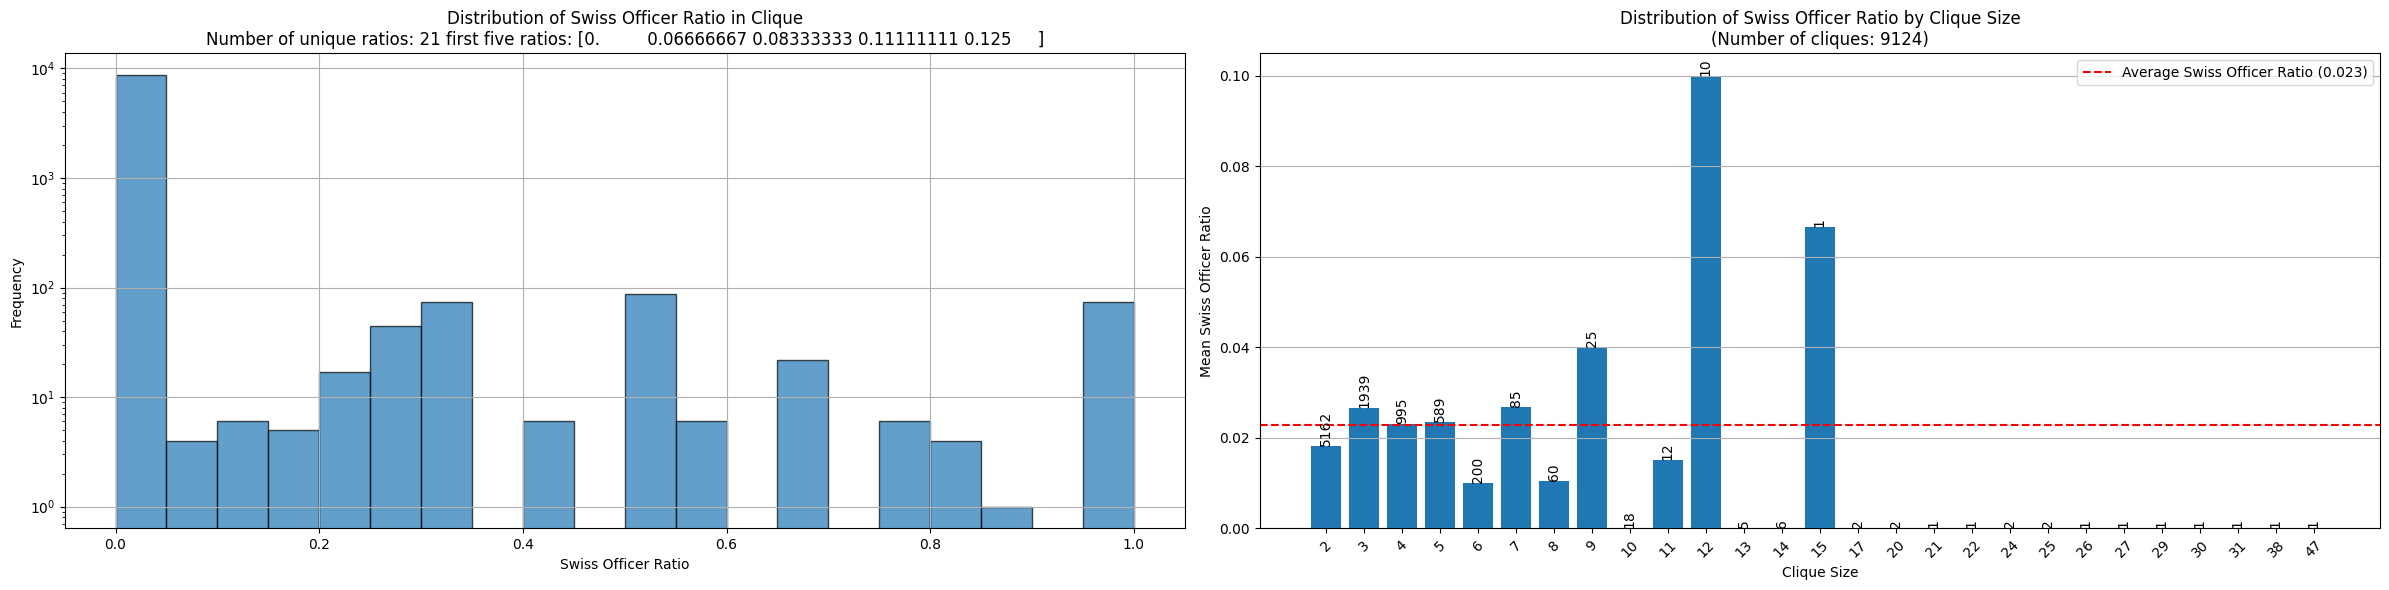

In [19]:
plot_swiss_officer_ratios_by_group(new_officers_graph, nx.find_cliques, 'clique')

Most cliques do not contain any swiss officers. The average swiss officer ratio (on a per clique basis) is 0.0227. There doesnt not seem to be many interesting patterns. One thing that is interesting is that there aren't many cliques where the swiss officer ratio is close to 0 or 1 but not exactly 0 or one (indicated by the histogram). also as the cliques get bigger there seem to be less cliques with any swiss officers. This could be due to the fact that the sample size is too small (there are only very few big cliques).

Let's also investigate the top 10 largest cliques.

In [21]:
cliques = list(nx.find_cliques(new_officers_graph))

largest_cliques = sorted(cliques, key=lambda x: len(x), reverse=True)[:10]

In [24]:
# list the nationality of the officers in the largest cliques
nationalities_per_clique = []
for clique in largest_cliques:
    # determine nationality by the country of the connected address
    nationalities = Counter()
    for officer in clique:
        for neighbor in G.neighbors(officer):
            if G.nodes[neighbor].get("node_type") == "Address":
                country = G.nodes[neighbor].get("country_codes")
                if country == "nan":
                    #country = G.nodes[neighbor].get("address")
                    print(f"Warning: No country found for address {G.nodes[neighbor]}")
                nationalities[country] += 1
    nationalities_per_clique.append(nationalities)

All these addresses with missing countries seem to reside in the BRITISH VIRGIN ISLANDS after a quick google search.

In [25]:
for i, nationalities in enumerate(nationalities_per_clique):
    print(f"clique {i+1} size: {sum(nationalities.values())}")
    print(nationalities)
    print()

clique 1 size: 92
Counter({'VGB': 88, 'nan': 4})

clique 2 size: 38
Counter({'URY': 38})

clique 3 size: 31
Counter({'USA': 31})

clique 4 size: 30
Counter({'URY': 30})

clique 5 size: 43
Counter({'ARG': 39, 'USA': 4})

clique 6 size: 41
Counter({'ARG': 41})

clique 7 size: 12
Counter({'GBR': 10, 'PRT': 1, 'GIB': 1})

clique 8 size: 51
Counter({'VGB': 48, 'nan': 3})

clique 9 size: 11
Counter({'GBR': 10, 'PRT': 1})

clique 10 size: 25
Counter({'URY': 24, 'ARG': 1})



All the big cliques are almost always homogeneous in terms of nationality. Only a few cliques have one officer from another country and only the clique 5 with size 43 has 4 officers from the USA.

We'll try to relax the condition a little bit and see what happens with n-cliques.

In [26]:
from networkx.algorithms.community import k_clique_communities, fast_label_propagation_communities, louvain_communities

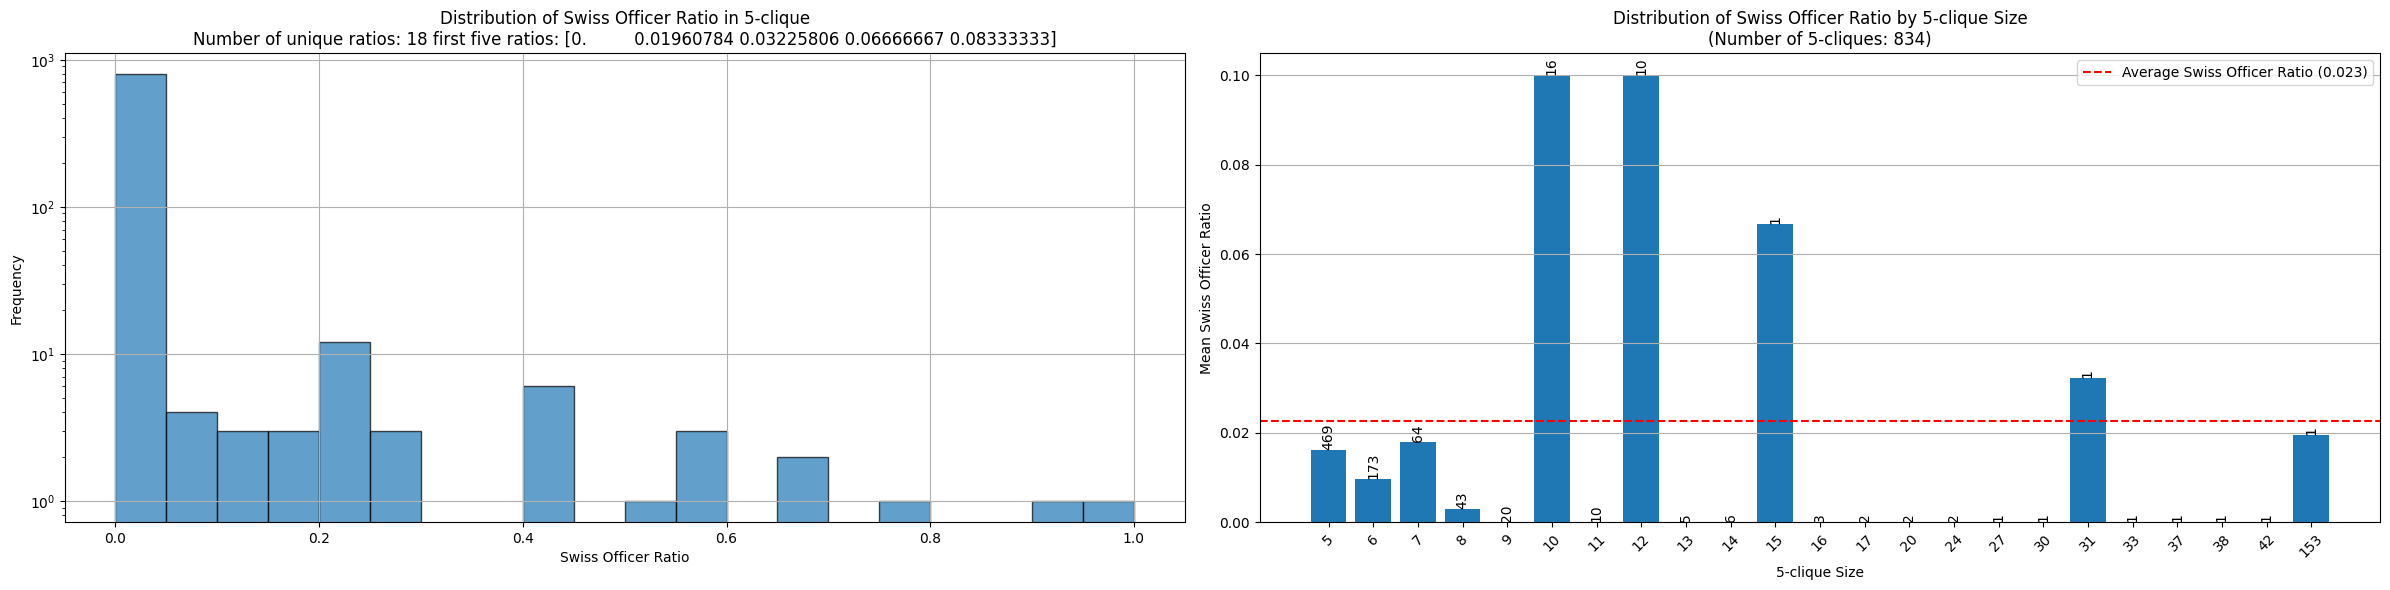

In [27]:
n = 5
plot_swiss_officer_ratios_by_group(new_officers_graph, lambda G: k_clique_communities(G, n), f'{n}-clique')

Nothing to exiciting here. Try with the smallest n-cliques (2-cliques) and see if there are any interesting patterns.

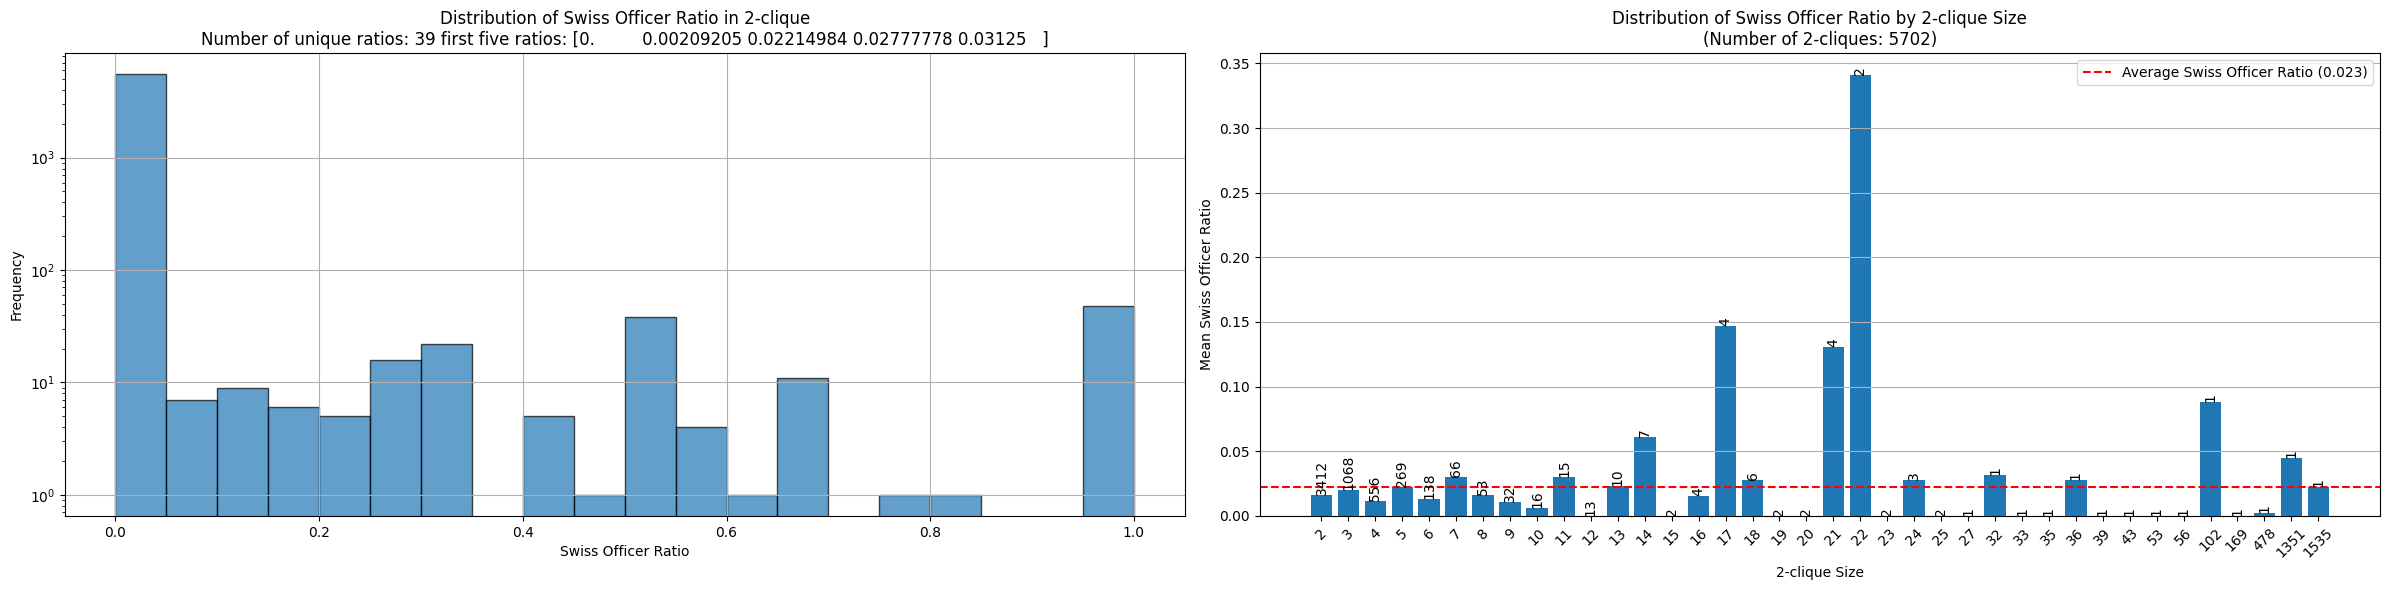

In [11]:
n = 2  # Example value for n
plot_swiss_officer_ratios_by_group(new_officers_graph, lambda G: k_clique_communities(G, n), f'{n}-clique')

Nope still only swiss and non swiss cliques. No mixed cliques.

Relax the condition even more with k-cores and see if there are any interesting patterns.

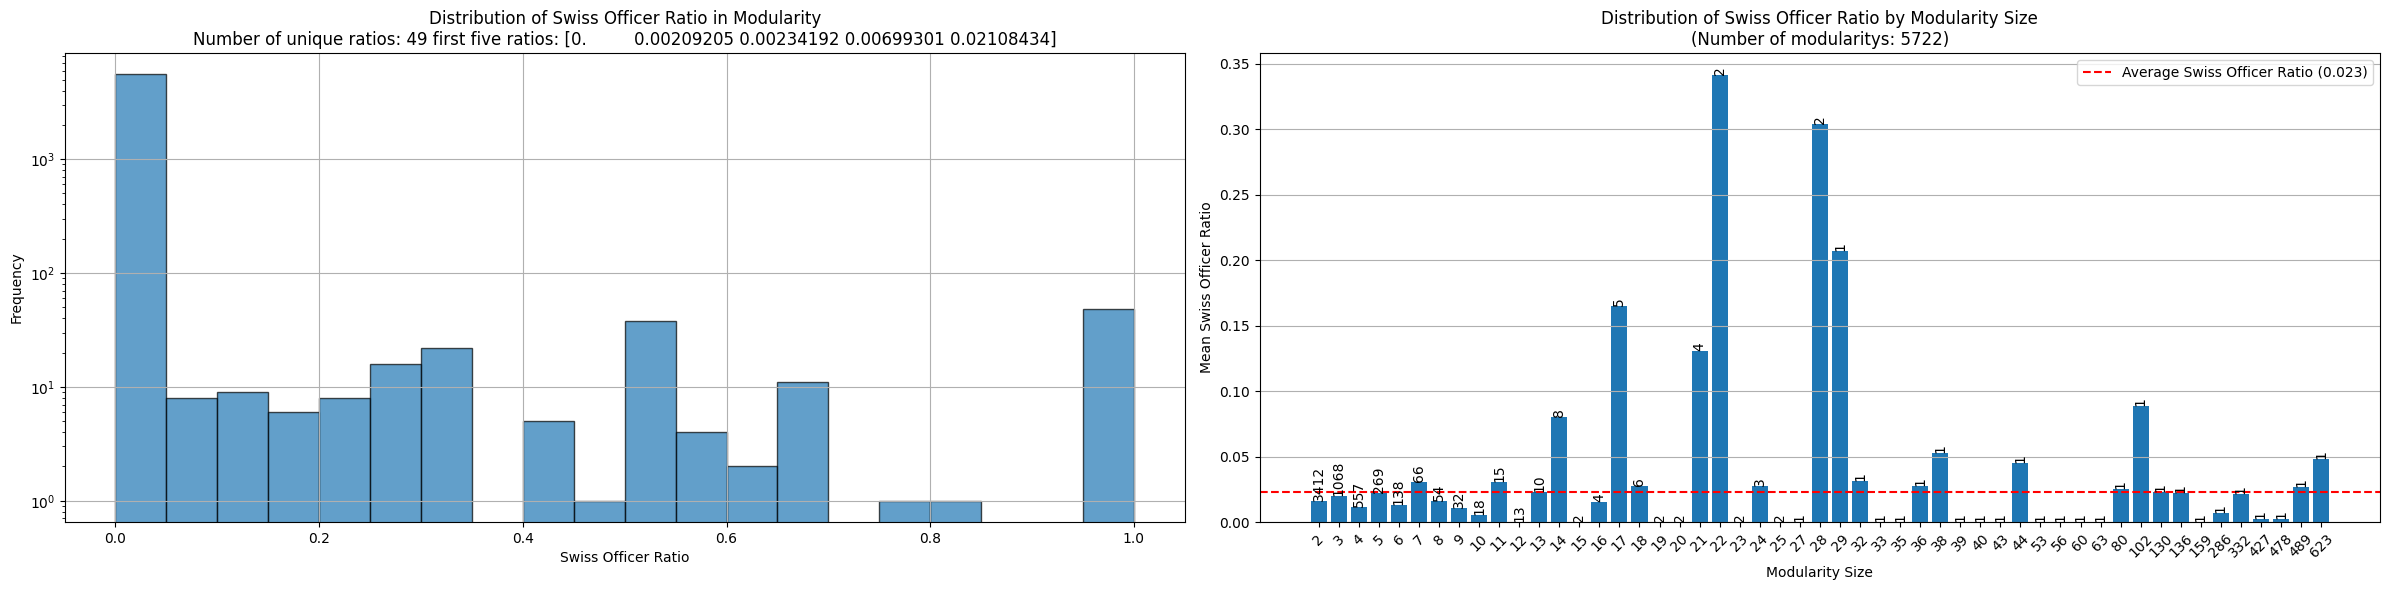

In [12]:
from networkx.algorithms.community import greedy_modularity_communities

plot_swiss_officer_ratios_by_group(new_officers_graph, greedy_modularity_communities, 'modularity')

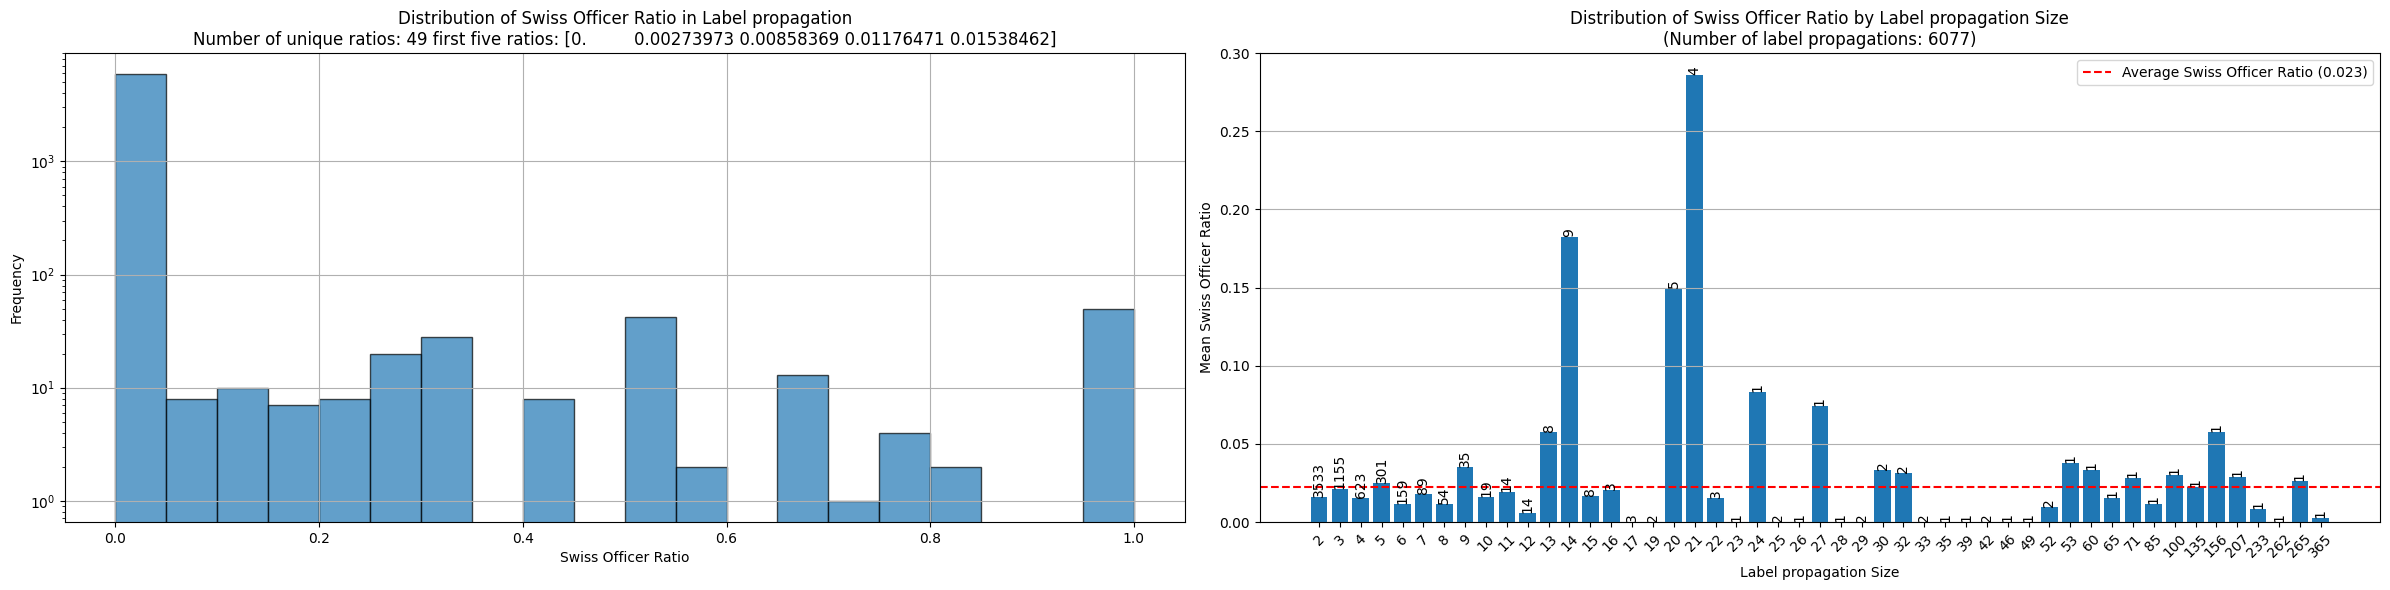

In [13]:

plot_swiss_officer_ratios_by_group(new_officers_graph, fast_label_propagation_communities, 'label propagation') 

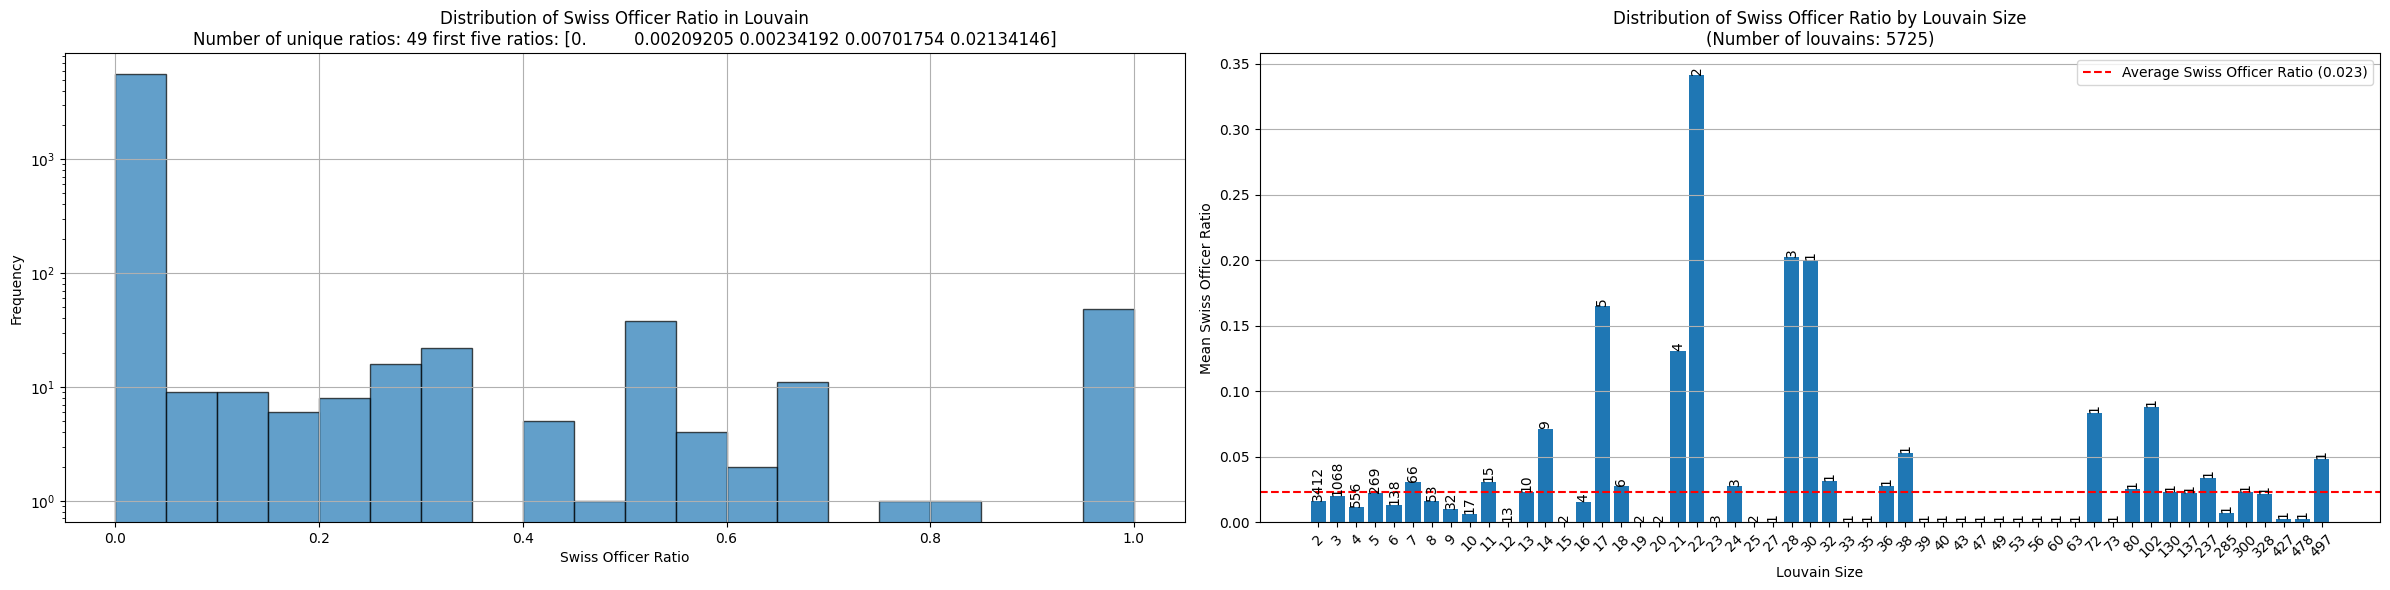

In [14]:
plot_swiss_officer_ratios_by_group(new_officers_graph, louvain_communities, 'louvain')

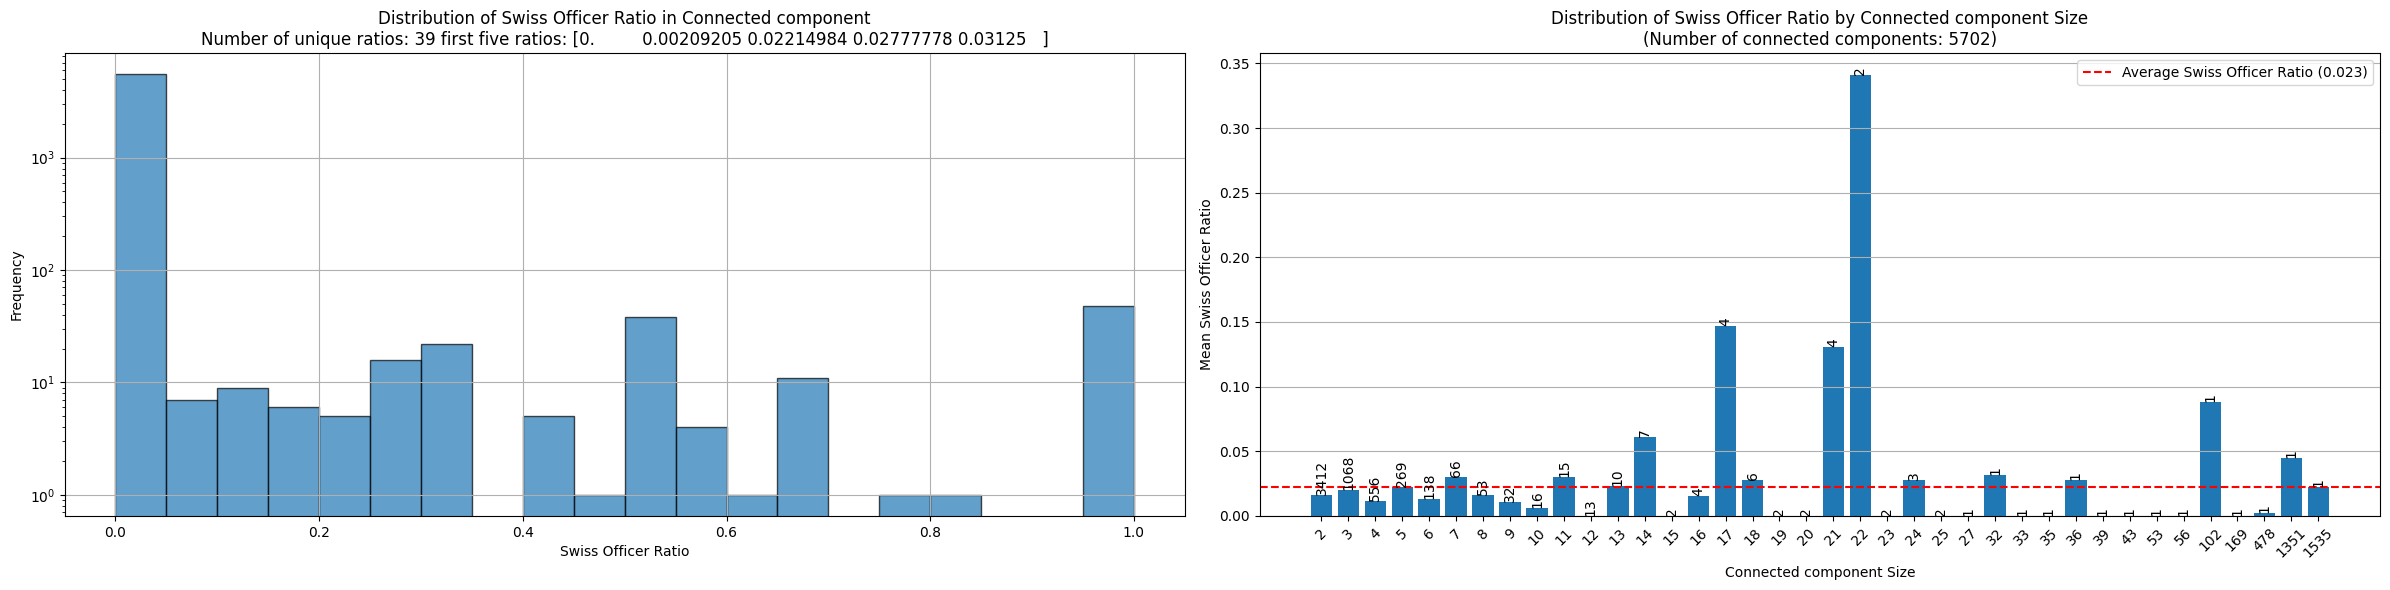

In [15]:
from networkx.algorithms.components import connected_components

plot_swiss_officer_ratios_by_group(new_officers_graph, connected_components, 'connected component')

This shows that there will never be a community that is mixed. It's always either swiss or not swiss.